# Setup

### Install the client library

In [1]:
!pip install -q google-generativeai

### Import libraries

In [1]:
import os
import google.generativeai as genai

Get your own API Key from: https://aistudio.google.com/app/apikey

Step 1: Export your API Key as an environment variable

- Windows: setx GEMINI_API_KEY "yourkey"

- Mac/Linux: export GEMINI_API_KEY="yourkey"

Step 2: Restart VSCode or whatever code environment you're using

In [2]:
genai.configure(api_key=os.environ['GEMINI_API_KEY'])

# Preparing Training Data

In [3]:
import pandas as pd

data_path = "c_train0.jsonl"
tests_path = "tests_all.jsonl"

df = pd.read_json(data_path, lines=True)
tests_df = pd.read_json(tests_path, lines=True)

In [4]:
df.head()

,id,buggy_submission_id,fixed_submission_id,problem_id,user_id,buggy_code,fixed_code,labels,change_count,line_hunks,errors
0,180,271,272,p00000,u772959354,#include <stdio.h>\n\nint main(void) {\n int ...,#include <stdio.h>\n\nint main(void) {\n int ...,"[literal.string.change, call.arguments.change,...",1,1.0,NaN
1,183,275,276,p00000,u690485037,#include <stdio.h>\n#define NINE 9\n\nint main...,#include <stdio.h>\n#define NINE 9\n\nint main...,"[literal.string.change, call.arguments.change,...",1,1.0,NaN
2,184,277,278,p00000,u226511948,"#include <stdio.h>\n\nint main() {\n\n int i,...","#include <stdio.h>\n\nint main() {\n\n int i,...","[literal.string.change, call.arguments.change,...",3,1.0,NaN
3,185,279,278,p00000,u226511948,"#include <stdio.h>\n\nint main() {\n\n int i,...","#include <stdio.h>\n\nint main() {\n\n int i,...","[literal.number.change, assignment.value.chang...",4,2.0,NaN
4,187,281,278,p00000,u226511948,"#include <stdio.h>\n\nint main() {\n\n int i,...","#include <stdio.h>\n\nint main() {\n\n int i,...","[literal.number.change, assignment.value.chang...",1,1.0,NaN


In [5]:
len(df)

22888

In [6]:
# Filter out rows where fixed code length > 5000 because the free Gemini Api has this length limit on the output.
filtered_df = df[df['fixed_code'].str.len() <= 5000]

# Merge the two DataFrames on 'problem_id' for faster access to 'input' and 'output'
merged_df = filtered_df.merge(tests_df[['problem_id', 'input', 'output']], on='problem_id', how='left')

# Create the 'text_input' and 'output' columns directly within the DataFrame
merged_df['text_input'] = (
    "Fix the given buggy code given the code's input and expected output:\n\n"
    "Buggy Code:\n" + merged_df['buggy_code'] + "\n\n"
    "Code Input:\n" + merged_df['input'] + "\n\n"
    "Code Expected Output:\n" + merged_df['output']
)
merged_df['output'] = merged_df['fixed_code']

# Filter out rows where prompt length > 40000 because the free Gemini Api has this length limit on the input.
filtered_merged_df = merged_df[merged_df['text_input'].str.len() <= 40000]

# Sample n rows per type of problem (problem_id)
n = 4
sampled_df = filtered_merged_df.groupby('problem_id', group_keys=False).apply(lambda x: x.sample(min(len(x), n), random_state=42),
                                                                              include_groups=False)

# Select relevant columns and save as CSV
sampled_df[['text_input', 'output']].to_csv('training_data.csv', index=False)

In [7]:
training_df = pd.read_csv('training_data.csv')

In [8]:
training_df.head()

,text_input,output
0,Fix the given buggy code given the code's inpu...,"\n#include <stdio.h>\n\nint main() {\n int i,..."
1,Fix the given buggy code given the code's inpu...,"#include <stdio.h>\nint main() {\n int i, j;\..."
2,Fix the given buggy code given the code's inpu...,"#include <stdio.h>\n\nint main() {\n int i, j..."
3,Fix the given buggy code given the code's inpu...,#include <stdio.h>\n\nint main(void) {\n int ...
4,Fix the given buggy code given the code's inpu...,#include <math.h>\n#include <stdio.h>\n\nint m...


In [9]:
len(training_df)

4514

# Training your model

Train it on this website: https://aistudio.google.com/app/tune

1. Import `training_data.csv` using the Import button below:

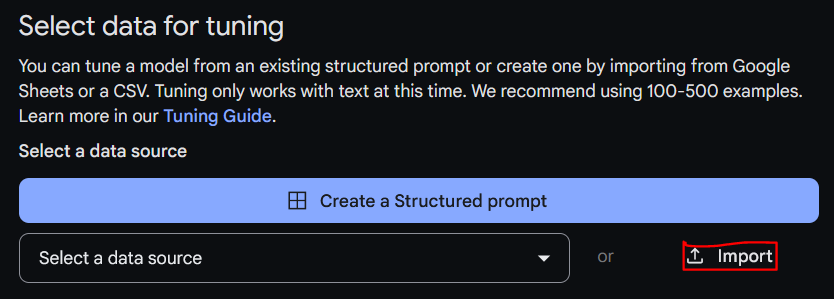

2. Set the following options and hit import again:

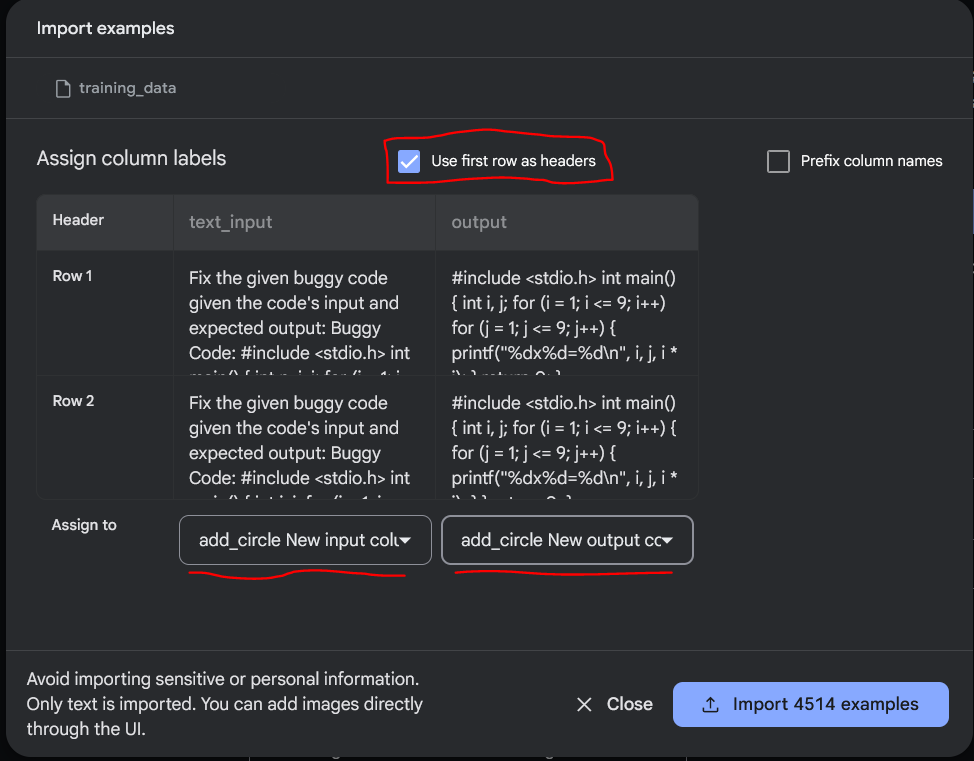

3. Finally set the hyperparameters to your liking and train the model.

# Use Trained Model with the Gemini API

Hit `Add API access` and select the project that has your API key.

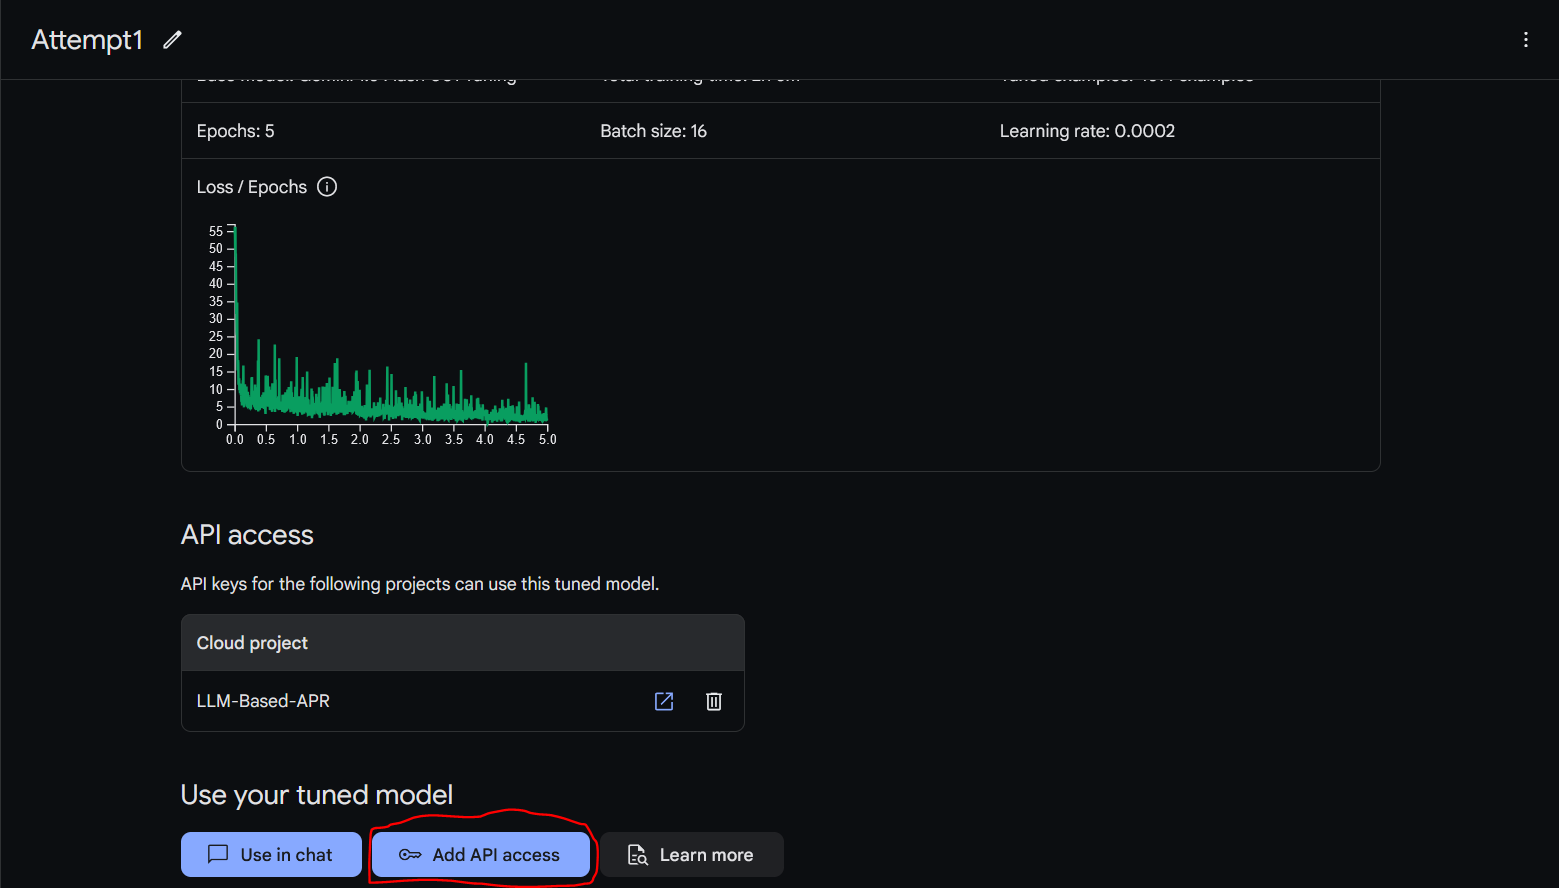